# Bayesian Cox Proportional Hazards
## Survival Analysis and Kaplan-Meier Survival Curves 

### Meghan Broadbent

_______________________________________________________________________________________________________________________

#### Counting processes, survival, and priors

Survival analysis is the study of time to event data, where $S(t) = \mathbb{P}[T > t]$ is the probability that a patient's survival is great than time $t$. Many forms of censoring and truncation can occur within a study, and in this example we'll focus on right censoring. Time to event data can be thought of as a counting process with a triple path, $\{N_i(t), Y_i(t), Z_i(t)\}$.  

For $i = 1, \dots, n$ subjects we count the number of events, $N_i(t)$, that have occurred by time $t$. With right censoring, we have that $N_i(t) = I[T_i \leq t, \delta_i = 1]$ is $0$ when a patient has no event of interest and $1$ when an event occurs (assuming no ties). $\delta_i(t) = I(T_i \leq C_i)$ is a $0$/$1$ censoring indicator where $0$ = no event and $1$ = event. To count the number of events up to time $t$ we let $N(t) = \sum_{i=1}^n N_i(t) = \sum_{t_i \leq t} \delta_i$. 

In order to compute these event times and relate them to survival, we let $dN(t)$ denote the change in our counting process $N(t)$ over a short interval of time $[t, t+dt)$. We then say $dN(t) = 1$ if an event occurs and $0$ else. Now, let $Y(t)$ be the number of patients at risk  just before time $t$ for having an event in the time interval $(t, t + dt)$, given by $Y_i(t) = I(T_i \geq t)$. Then, the total number of patients at by time $t$ is $Y(T) = \sum_t Y_i(t)$. We then let $Z_i(T)$ be the covariate vector for the $i^{th}$ patient, often dependent on time.  

Counting processes are based on prior history about survival, censorship, and covariates. We refer to these three dependencies as filtration denoted by $\mathcal{F}_{t^{-}}$. Hence, $\mathcal{F}_{t^{-}}$ represent the triple path history at the instance just prior to time $t$. To understand the survival curve for a cohort of patients, we have to understand the intensity at which the group experiences the event of interest. We let the intensity function $\lambda(t) = \lim_{\Delta t \rightarrow 0} \dfrac{\mathbb{P}[t \leq T < t + \Delta t \mid T \geq t, C \geq T]}{\Delta t}$, which is essentially in and of itself a counting process where, given a single event, it is the hazard function with time independent of censoring. We can then express the intensity function over an interval of time (conditional on the process history just prior to time $t$) as $\mathbb{P}[dN(t)] = \mathbb{E}[dN(t)\mid \mathcal{F}_{t^{-}}] = \lambda(t)dt$. For the $i^{th}$ individual this becomes $\mathbb{E}[dN_i(t) \mid \mathcal{F}_{t^-}] = \mathbb{E}[dN_i(t) \mid Y_i(t)] = Y_i(t) \lambda(t)dt$. 

_A cox model is considered a special case of the counting process as it counts the number of events and ranks the order of event times_. As before we let $N_i(t)$ be the number of observed events with $t\geq0$ and $N_i(0) = 0$. Then, the hazard function for the $i^{th}$ individual at time $t$ given a baseline hazard of $\lambda_0$ is given by $\lambda_i(t) = \lambda_0(t) e^{[Z^T_i(t)\beta]}$. In this scenario, $Y_i(t) = 1$ until an event or censoring occurs and $0$ otherwise. The likelihood we ultimately wish to approximate is $L \propto \prod_{i=1}^n \left[ \prod_{t \geq 0} \left( \dfrac{Y_i(t)e^{[Z^T_i(t) \beta]}}{\sum_l Y_l(t) e^{[Z^T_l(t) \beta]}}\right) \right]^{dN_i(t)}$

To estimate this non-parametrically, we have to come up with priors for the unknown parameters $\beta$ and hazard $\lambda(t)$. Following Bayes rule, we have a joint posterior distribution with $\mathbb{P}[\beta, \lambda(t) \mid N(t)] \propto \mathbb{P}[N(t) \mid \beta, \lambda(t)] \times \mathbb{P}[\beta] \mathbb{P}[\lambda(t)]$. We let the change in our counting process be a poisson with mean (and variance) the intensity function, hence $dN(t) \sim$ Poisson($\lambda(t)dt$). 

The conjugate prior for the Poisson mean, $\lambda$, is the gamma distribution. Why? Since a sum of Poisson probabilities can be evaluated using the incomplete gamma function, and since a poisson likelihood with a gamma prior provides a gamma posterioer, then if $dN(t) \sim$ Poisson($\lambda(t)dt$) and we let a gamma function be the prior for $\lambda(t)dt$, then gamma will be a conjugate prior. We will scale our belief in this guess by $c$, a small fixed constant. Thus we let $\lambda(t) \sim$ Gamma($c\lambda(t), c$). This model should be sufficient and realistic, as we generally have some underlying guess as to what the hazard function will be based on prior knowledge of the subject matter, where our belief depends on our prior knowledge. 

Lastly, we assume our beta parameter (in this case the estimate of the hazard ratio) is normally distributed with mean 0 and a large variance, i.e., $\beta \sim \mathcal{N}(0, \sigma^2)$.

#### Analysis of survival times for patients with leukemia receiving either a placebo or therapeutic treatment using Bayesian Cox Proportional Hazards

In [5]:
install.packages("rstan")
#install.packages("coda")
install.packages("ggthemes")
library(ggthemes)
#install.packages("ggmcmc")
#library(ggmcmc)
library(rstan)
library(dplyr)
library(ggplot2)
require(gridExtra)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.14.2, packaged: 2017-03-19 00:42:29 UTC, GitRev: 5fa1e80eb817)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [7]:
#set options and use cores wisely
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

In [8]:
#Number of obs
N = 42 
#Number of time measurements (months)
M = 17
#observations over time
obs_t = c(1, 1, 2, 2, 3, 4, 4, 5, 5, 8, 8, 8, 8, 11, 11, 12, 12, 15, 
          17, 22, 23, 6, 6, 6, 6, 7, 9, 10, 10, 11, 13, 16, 17, 19, 20, 
          22, 23, 25, 32, 32, 34, 35) 
#censoring
cens = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
         1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 
         0) 

#effect with beta 
Z = c(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
      0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5, -0.5, 
      -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 
      -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5) 

#time in months
t = c(1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 22, 23) 

Running a STAN model with the following specified:  

$\beta \sim \mathcal{N}(0, \sigma^2)$ where $\sigma^2$ = 1000   
$dN_i(t) \sim$ Poisson($\lambda_i(t)dt$)  
$d\lambda_0(t) \sim $ Gamma($cd \lambda_0(t), c)$ where $c$ = 0.001 

In [9]:
leuk_model = stan(file="leuk.stan",
                  data = list(N=N, M=M, obs_t=obs_t, cens=cens, Z=Z), 
                  iter=10000, #iterations
                  chains=2 #independent monte carlo runs
                  )

hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from file414307a7553.cpp:8:
In file included from /Users/meg/anaconda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Users/meg/anaconda/lib/R/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Users/meg/anaconda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Users/meg/anaconda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /Users/meg/anaconda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /Users/meg/anaconda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /Users/meg/anaconda/lib/R/library/BH/include/boost/math/tools/config.hpp:13:
In file included from /Users/meg/anaconda/lib/R/library/BH/include/boost/config.hpp:39:
/Users/meg/anaconda/lib/R/library/BH/include/boost/config/compiler/clang.hpp:196:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro red

In [141]:
print(leuk_model)

Inference for Stan model: leuk.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

                 mean se_mean   sd    2.5%     25%     50%     75%   97.5%
beta             1.54    0.00 0.42    0.75    1.25    1.53    1.81    2.40
dL0[1]           0.04    0.00 0.03    0.00    0.02    0.03    0.05    0.10
dL0[2]           0.04    0.00 0.03    0.00    0.02    0.03    0.05    0.11
dL0[3]           0.02    0.00 0.02    0.00    0.01    0.01    0.03    0.08
dL0[4]           0.04    0.00 0.03    0.01    0.02    0.04    0.06    0.13
dL0[5]           0.05    0.00 0.04    0.01    0.02    0.04    0.07    0.14
dL0[6]           0.08    0.00 0.05    0.02    0.05    0.07    0.11    0.20
dL0[7]           0.03    0.00 0.03    0.00    0.01    0.02    0.04    0.11
dL0[8]           0.12    0.00 0.06    0.03    0.07    0.11    0.15    0.27
dL0[9]           0.04    0.00 0.04    0.00    0.01    0.03    0.06    0.15
dL0[10]          0.08  

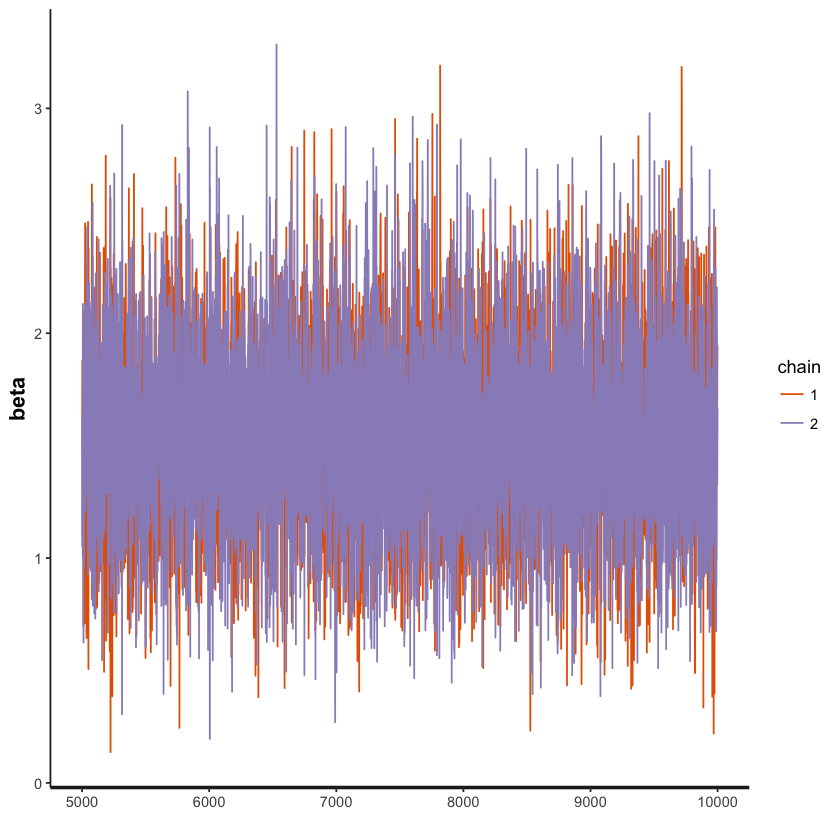

In [52]:
traceplot(leuk_model, pars="beta")

#### With an estimated Hazard Ratio (HR) of 1.54, patients receiving the control (placebo) treatment are 54% more likely to die than those receiving the experimental treatment

In [11]:
#extract data to grab the placebo and treatment survival probabilities for each month
leuk_ext = extract(leuk_model) #extract will get masked by ggmcmc :(
colMeans(leuk_ext$S_placebo)
colMeans(leuk_ext$S_treat)

[1] 0.92628139 0.85272962 0.81548210 0.74248562 0.66967833 0.56296118
 [7] 0.52937011 0.41379624 0.38024264 0.31952175 0.25697556 0.22449802
[13] 0.19468165 0.16498325 0.13915471 0.08610731 0.04368153

[1] 0.9827266 0.9643569 0.9546522 0.9346359 0.9131099 0.8780865 0.8659662
 [8] 0.8191261 0.8035680 0.7724003 0.7350297 0.7125754 0.6896173 0.6635958
[15] 0.6378132 0.5681882 0.4773722

In [13]:
#placebo probs
sp = c(0.926281393416887, 0.852729620418787, 0.815482103621276, 0.742485622490814, 0.669678329725887, 
      0.562961175194686, 0.529370111615247, 0.413796241966292, 0.380242640208125, 0.3195217547204, 
      0.256975555507053, 0.224498018588, 0.194681649859429, 0.164983247482071, 0.139154713761431, 
      0.0861073070898745, 0.0436815300005772)

#treatment probs
st = c(0.982726564477572, 0.964356943843366, 0.954652165444568, 0.934635901605721, 0.913109868807541, 
       0.878086478197503, 0.865966212908423, 0.819126122222634, 0.803568040756891, 0.77240029403238, 
       0.735029700908402, 0.712575384289167, 0.689617308905352, 0.663595767715221, 0.637813151377892, 
       0.568188243344803, 0.477372199301296)


spl = c(0.80, 0.69, 0.64, 0.56, 0.48, 0.37, 0.34, 0.24, 0.21, 
        0.16, 0.11, 0.09, 0.07, 0.05, 0.04, 0.01, 0.00) 

spu = c(0.99, 0.96, 0.94, 0.88, 0.83, 0.74, 0.72, 0.61, 0.57, 
        0.51, 0.44, 0.40, 0.37, 0.33, 0.30, 0.22, 0.15) 

stl = c(0.95, 0.91, 0.89, 0.86, 0.82, 0.76, 0.74, 0.67, 0.65, 
        0.60, 0.55, 0.52, 0.49, 0.45, 0.42, 0.33, 0.24)

stu = c(1.00, 0.99, 0.99, 0.98, 0.97, 0.95, 0.95, 0.92, 0.92, 
        0.90, 0.88, 0.87, 0.85, 0.84, 0.82, 0.78, 0.71)

#months
t1= c(1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 22, 23)

#concatenate into dataframe
s.prob = data.frame(t1, sp, st, spl, spu, stl, stu)

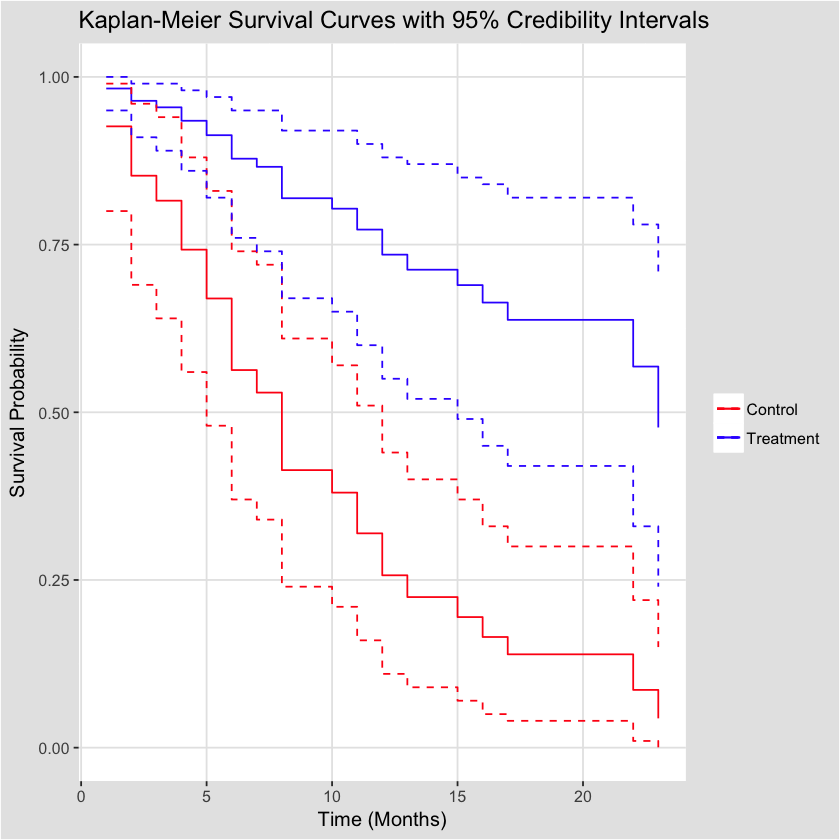

In [50]:
#plot the kaplan-meier curves
cols <- c("Treatment" = "#3705ff", "Control" = "#ff0314")
s.prob %>%
  ggplot(aes(x = t1, y = sp, color="Control")) + 
  geom_step() + 
  geom_step(aes(x=t1, y=st, color="Treatment")) +
  geom_step(aes(x=t1, y=spu, color="Control"), linetype=2) +
  geom_step(aes(x=t1, y=spl, color="Control"), linetype=2) +
  geom_step(aes(x=t1, y=stu, color="Treatment"), linetype=2) + 
  geom_step(aes(x=t1, y=stl, color="Treatment"), linetype=2) +
  xlab("Time (Months)") + 
  ylab("Survival Probability") + 
  ggtitle("Kaplan-Meier Survival Curves with 95% Credibility Intervals") + 
  theme_igray() +
  scale_colour_manual(name="",values=cols)

In [27]:
#transfer to dataframe for further plotting
leuk_df = as.data.frame(leuk_model)

In [43]:
#function to plot a handful of samples over time for the drugs
histplts <- function(data, col, labx){
data %>%
    ggplot(aes(x=leuk_df[,col])) + 
    geom_density() + 
    xlab(labx) + 
    ylab("") + 
    theme_igray()
}

In [48]:
#s_p[1] = 19th
plt.sp1 = histplts(leuk_df, 19, labx="Control: t=1")
#s_p[7] = 25th
plt.sp2 = histplts(leuk_df, 25, labx="Control: t=7")
#s_p[12] = 30th
plt.sp3 = histplts(leuk_df, 30, labx="Control: t=12")
#s_p[17] = 35th
plt.sp4 = histplts(leuk_df, 35, labx="Control: t=17")
#s_t[1] = 36th
plt.st1 = histplts(leuk_df, 36, labx="Treatment: t=1")
#s_t[7] = 42nd
plt.st2 = histplts(leuk_df, 42, labx="Treatment: t=7")
#s_t[12] = 47th
plt.st3 = histplts(leuk_df, 47, labx="Treatment: t=12")
#s_t[17] = 52nd
plt.st4 = histplts(leuk_df, 52, labx="Treatment: t=17")

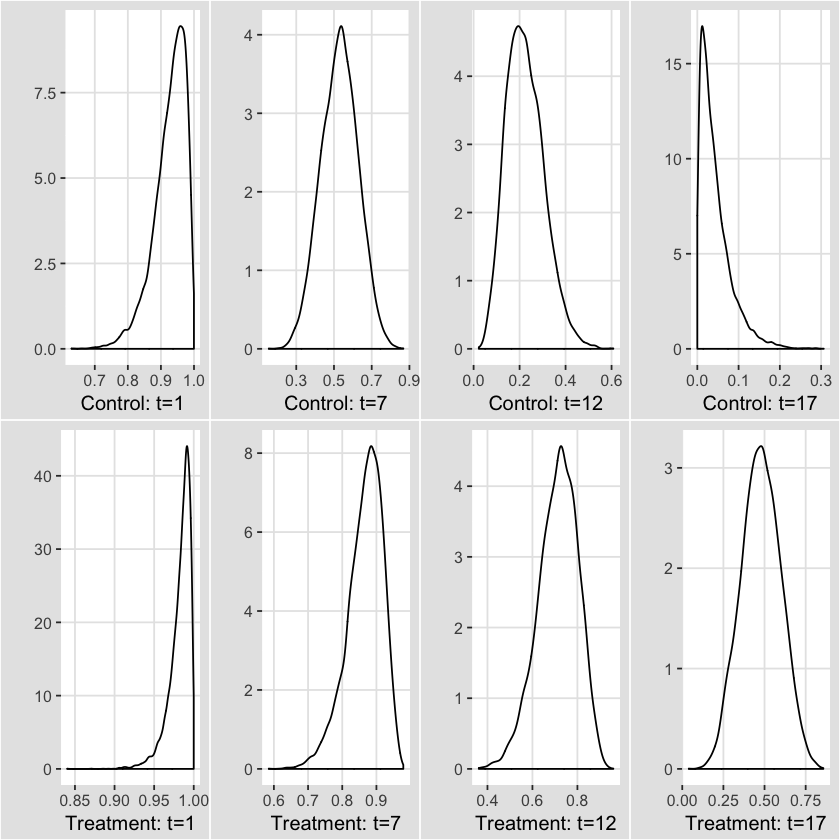

In [49]:
grid.arrange(plt.sp1, plt.sp2, plt.sp3, plt.sp4, 
             plt.st1, plt.st2, plt.st3, plt.st4,
             ncol=4)

# $\mathcal{FIN}$ 